In [2]:
import torch
import yaml
import os
import sys
sys.path.append('/mnt/weka/scratch/yang.liu3/pyworkspace/3DGS')

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from scene import Scene
from gaussian_renderer import render
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams
from utils.loss_utils import l1_loss, ssim

In [3]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

In [4]:
config1 = '../config/org_ue_aerial_20_block1cam.yaml'
config2 = '../config/org_ue_aerial_20_block2cam.yaml'
save_dir = '../output/cat_ue_aerial_20_blockFcam'
iteration = 30_000

with open(config1) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp1, op1, pp1 = parse_cfg(cfg)
    setattr(lp1, 'config_path', config1)

config1_name = os.path.splitext(os.path.basename(config1))[0]
lp1.source_path = os.path.join("../", lp1.source_path)
lp1.model_path = os.path.join("../output/", config1_name)

with open(config2) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp2, op2, pp2 = parse_cfg(cfg)
    setattr(lp2, 'config_path', config2)

config2_name = os.path.splitext(os.path.basename(config2))[0]
lp2.source_path = os.path.join("../", lp2.source_path)
lp2.model_path = os.path.join("../output/", config2_name)

In [5]:
with torch.no_grad():
    gaussians1 = GaussianModel(lp1.sh_degree)
    scene1 = Scene(lp1, gaussians1, load_iteration=iteration, shuffle=False)
    print(f'Loaded {lp1.model_path}\n')

    gaussians2 = GaussianModel(lp2.sh_degree)
    scene2 = Scene(lp2, gaussians2, load_iteration=iteration, shuffle=False)
    print(f'Loaded {lp2.model_path}')

Loading trained model at iteration 30000
Reading camera 70/70
Loading Training Cameras
[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1
Loading Test Cameras
Loaded ../output/org_ue_aerial_20_block1cam

Loading trained model at iteration 30000
Reading camera 70/70
Loading Training Cameras
Loading Test Cameras
Loaded ../output/org_ue_aerial_20_block2cam


In [39]:
assert lp1.sh_degree == lp2.sh_degree, "Two blocks should have the same sh_degree"
sh_degree = lp1.sh_degree
fused_gaussians = GaussianModel(sh_degree)

# Fuse properties of two blocks
fused_gaussians._xyz = torch.cat([gaussians1._xyz, gaussians2._xyz], dim=0)
fused_gaussians._features_dc = torch.cat([gaussians1._features_dc, gaussians2._features_dc], dim=0)
fused_gaussians._features_rest = torch.cat([gaussians1._features_rest, gaussians2._features_rest], dim=0)
fused_gaussians._scaling = torch.cat([gaussians1._scaling, gaussians2._scaling], dim=0)
fused_gaussians._rotation = torch.cat([gaussians1._rotation, gaussians2._rotation], dim=0)
fused_gaussians._opacity = torch.cat([gaussians1._opacity, gaussians2._opacity], dim=0)
fused_gaussians.max_radii2D = torch.cat([gaussians1.max_radii2D, gaussians2.max_radii2D], dim=0)

save_path = os.path.join(save_dir, "point_cloud", "iteration_" + str(iteration), "point_cloud.ply")
fused_gaussians.save_ply(save_path)
print(f"Saving point cloud to {save_path}")

Saving point cloud to ../output/cat_ue_aerial_20_blockFcam/point_cloud/iteration_30000/point_cloud.ply


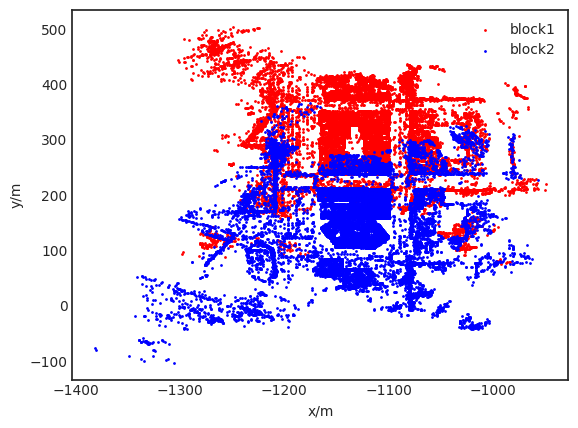

In [51]:
# show area of two blocks under BEV
plt.figure()
plt.style.use('seaborn-white')
plt.scatter(gaussians1._xyz[::100, 0].detach().cpu(), gaussians1._xyz[::100, 1].detach().cpu(), s=1, c='r', label='block1')
plt.scatter(gaussians2._xyz[::100, 0].detach().cpu(), gaussians2._xyz[::100, 1].detach().cpu(), s=1, c='b', label='block2')
plt.legend()
plt.xlabel('x/m')
plt.ylabel('y/m')
plt.show()

In [7]:
with torch.no_grad():
    views1 = scene1.getTestCameras()  # getTrainCameras, getTestCameras
    bg_color1 = [1,1,1] if lp1.white_background else [0, 0, 0]
    background1 = torch.tensor(bg_color1, dtype=torch.float32, device="cuda")

    views2 = scene2.getTestCameras()  # getTrainCameras, getTestCameras
    bg_color2 = [1,1,1] if lp2.white_background else [0, 0, 0]
    background2 = torch.tensor(bg_color2, dtype=torch.float32, device="cuda")

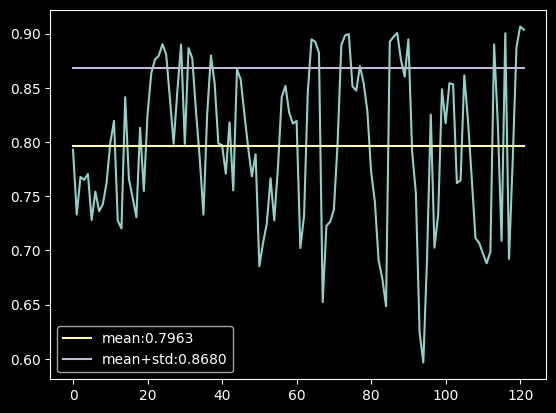

In [9]:
block_id = 1  # 1 or 2
loss_list = []
with torch.no_grad():
    views = scene1.getTrainCameras() + scene2.getTrainCameras()
    scene_idx = [1] * len(scene1.getTrainCameras()) + [2] * len(scene2.getTrainCameras())
    for i in range(len(views)):
        view = views[i]
        render_pkg_fused = render(view, fused_gaussians, pp1, background1)
        image_fused, _, _, _, _ = render_pkg_fused["render"], render_pkg_fused["viewspace_points"], render_pkg_fused["visibility_filter"], render_pkg_fused["radii"], render_pkg_fused["geometry"]
        image_fused = image_fused
        gt_image = view.original_image

        loss = ssim(image_fused, gt_image)
        loss_list.append(loss.cpu())

plt.plot(loss_list)
loss_mean = np.mean(loss_list)
loss_std = np.std(loss_list)
plt.plot([loss_mean] * len(loss_list), label=f"mean:{loss_mean:.4f}")
plt.plot([loss_mean + loss_std] * len(loss_list), label=f"mean+std:{loss_mean + loss_std:.4f}")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


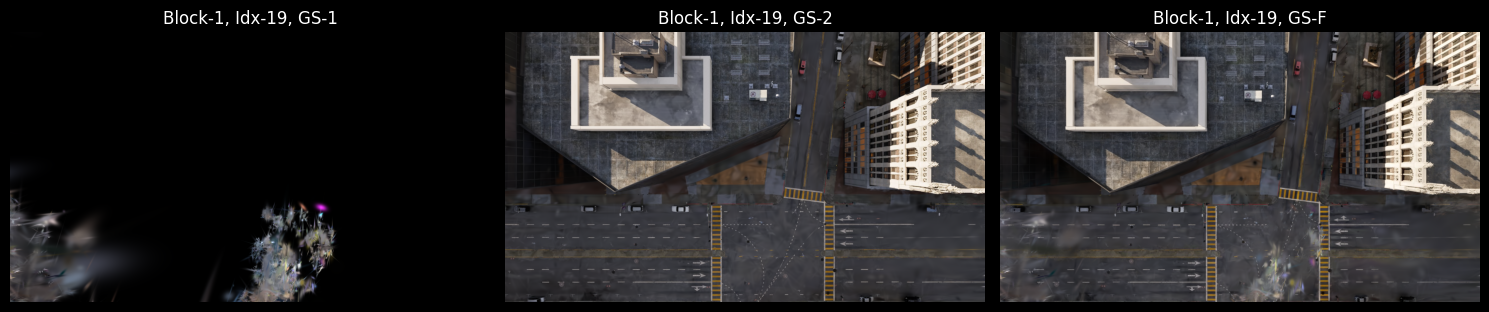

In [37]:
idx = 19
mask = [i for i in range(len(scene_idx)) if loss_list[i] >= loss_mean + loss_std]

with torch.no_grad():
    view = views[mask[idx]]
    render_pkg_fused = render(view, fused_gaussians, pp1, background1)
    render_pkg_block1 = render(view, gaussians1, pp1, background1)
    render_pkg_block2 = render(view, gaussians2, pp1, background1)

image_fused, _, _, _, _ = render_pkg_fused["render"], render_pkg_fused["viewspace_points"], render_pkg_fused["visibility_filter"], render_pkg_fused["radii"], render_pkg_fused["geometry"]
image_fused = image_fused.cpu().numpy().transpose(1,2,0)

image_block1, _, _, _, _ = render_pkg_block1["render"], render_pkg_block1["viewspace_points"], render_pkg_block1["visibility_filter"], render_pkg_block1["radii"], render_pkg_block1["geometry"]
image_block1 = image_block1.cpu().numpy().transpose(1,2,0)

image_block2, _, _, _, _ = render_pkg_block2["render"], render_pkg_block2["viewspace_points"], render_pkg_block2["visibility_filter"], render_pkg_block2["radii"], render_pkg_block2["geometry"]
image_block2 = image_block2.cpu().numpy().transpose(1,2,0)

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(image_block1)
plt.title(f'Block-{block_id}, Idx-{idx}, GS-1')
plt.axis('off')
plt.tight_layout()
plt.subplot(132)
plt.imshow(image_block2)
plt.title(f'Block-{block_id}, Idx-{idx}, GS-2')
plt.axis('off')
plt.tight_layout()
plt.subplot(133)
plt.imshow(image_fused)
plt.title(f'Block-{block_id}, Idx-{idx}, GS-F')
plt.axis('off')
plt.tight_layout()

plt.show()